In [2]:
from itertools import product
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import *
from thermal_models import make_model
import porepy as pp


model = make_model(
    {
        "geometry": 1,
        "barton_bandis_stiffness_type": 2,
        "friction_type": 1,
        "grid_refinement": 1,
        "solver": 0,
    }
)
model.prepare_simulation()
model.before_nonlinear_loop()
model.before_nonlinear_iteration()
model.assemble_linear_system()

/home/porepy/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:14: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import trange  # type: ignore




Sim time: 0, Dt: 0.5
sticking: 4, sliding: 0, open: 0


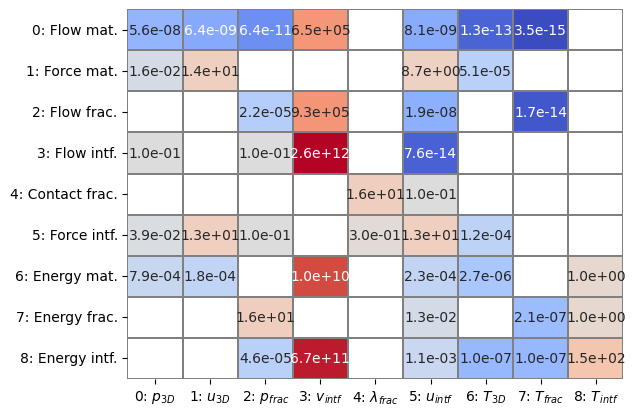

In [3]:
mat, rhs, state, iterate, dt = load_matrix_rhs_state_iterate_dt(
    load_data(f"../../stats/{model.simulation_name()}.json"), 10, "../../matrices"
)
model.linear_system = mat, rhs
model.bmat.mat = mat
model.bmat.plot_max()
J = model.bmat

# Why no temperature??

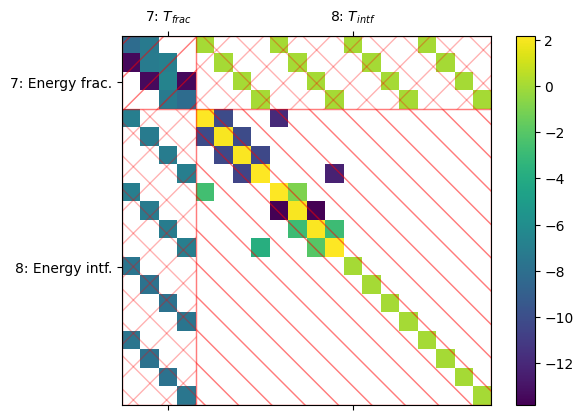

In [4]:
J[[7, 8]].matshow_blocks()

Solve  took: 0.0
True residual permuted: 9.305386828154654e-11
PETSc Converged Reason: 2


{'mat_Q': BlockMatrixStorage of shape (488, 488) with 9046 elements with 2x2 active groups,
 'rhs_Q': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,

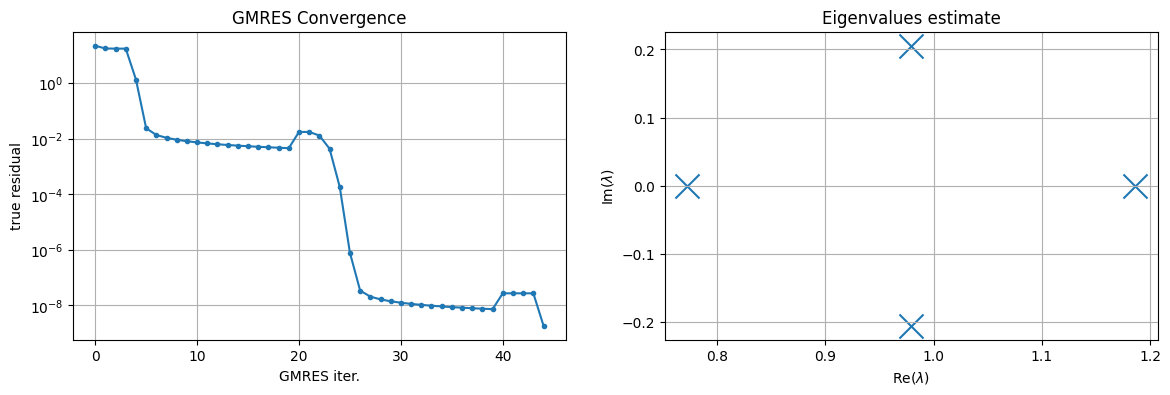

In [5]:
from block_matrix import FieldSplitScheme
from fixed_stress import make_fs_analytical
from mat_utils import (
    extract_diag_inv,
    inv_block_diag,
    PetscAMGFlow,
    PetscAMGFlow,
    PetscAMGMechanics,
    PetscILU,
)
from pp_utils import build_mechanics_near_null_space

solve_petsc_new(
    J[[0,6]],
    solve_schema=FieldSplitScheme(
        # # Exactly eliminate contact mechanics (assuming linearly-transformed system)
        # groups=[4],
        # solve=lambda bmat: inv_block_diag(mat=bmat[[4]].mat, nd=model.nd),
        # complement=FieldSplitScheme(
            # Eliminate interface flow, it is not coupled with (1, 4, 5)
            # Use diag() to approximate inverse and ILU to solve linear systems
            # groups=[3],
            # solve=lambda bmat: PetscILU(bmat[[3]].mat),
            # invertor=lambda bmat: extract_diag_inv(bmat[[3]].mat),
            # complement=FieldSplitScheme(
                # # Eliminate elasticity. Use AMG to solve linear systems and fixed
                # # stress to approximate inverse.
                # groups=[1, 5],
                # solve=lambda bmat: PetscAMGMechanics(
                #     mat=bmat[[1, 5]].mat,
                #     dim=model.nd,
                #     null_space=build_mechanics_near_null_space(model),
                # ),
                # invertor_type="physical",
                # invertor=lambda bmat: make_fs_analytical(model, bmat, blocks=[0, 2, 6, 7, 8]).mat,
                # complement=FieldSplitScheme(
                    # Use AMG to solve mass balance.
                    groups=[0],
                    solve=lambda bmat: PetscAMGFlow(mat=bmat[[0,]].mat),
                    invertor=lambda bmat: inv_block_diag(bmat[[0,]].mat, nd=1, lump=False),
                    # complement=FieldSplitScheme(
                    #     groups=[8],
                    #     solve=lambda bmat: inv_block_diag(
                    #         bmat[[8]].mat, nd=model.nd, lump=True
                    #     ),
                        complement=FieldSplitScheme(
                            groups=[6],
                            solve=lambda bmat: PetscAMGFlow(bmat[[6,]].mat),
                        ),
                    # ),
                # ),
            # ),
        # ),
    ),
    pc_side="right",
    # Qright=model.Qright(),
)

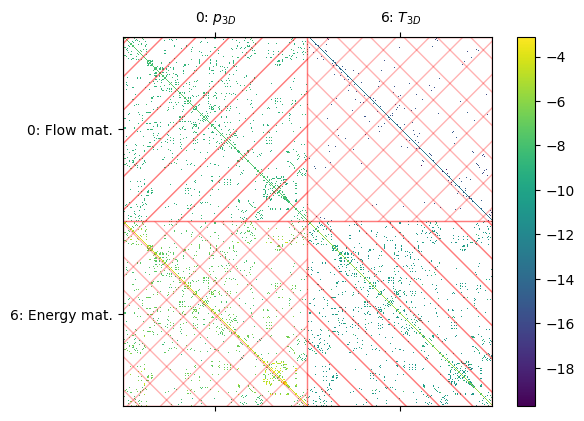

In [6]:
J[[0,6]].matshow_blocks()

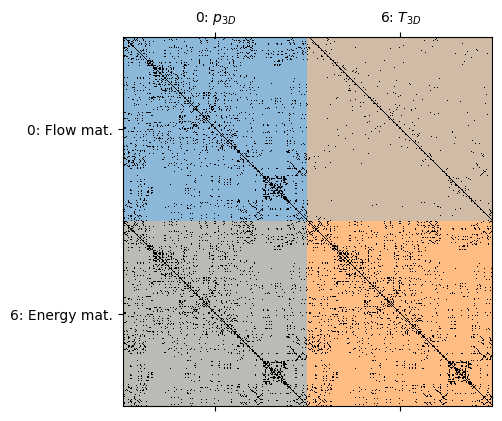

In [7]:
tmp_mat = J[[0,6]]
tmp_mat.color_spy()

In [8]:
tmp_mat.active_groups[0]

((0, 6), (0, 6))

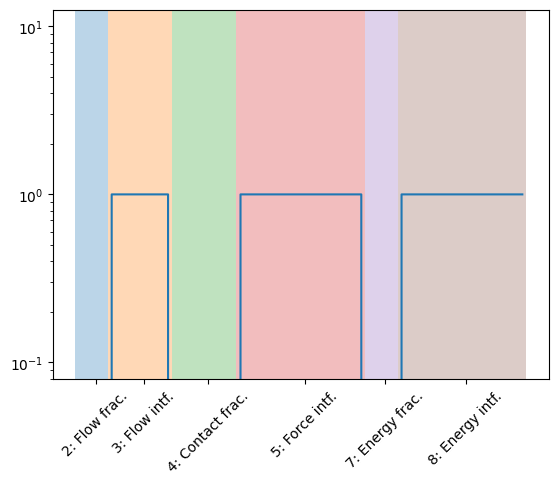

In [92]:
tmp_mat = model.bmat[[2,3,4,5,7,8]]
R = tmp_mat.make_restriction_matrix([3,5,8]).mat

tmp_mat.color_local_rhs(R.T @ (R @ np.ones(tmp_mat.shape[0])))
# .make_restriction_matrix([3, 4, 5, 8]).color_spy()

In [86]:
from block_matrix import BlockMatrixStorage

class TwoStagePreconditioner:

    def __init__(self, mat: BlockMatrixStorage):
        self.mat: BlockMatrixStorage = mat
        self.shape = mat.shape

    def dot(self, x: np.ndarray) -> np.ndarray:
        J00 = self.mat[0,0]
        R1 = self.mat.make_restriction_matrix([0]).mat
        x0_local = R1 @ x
        M1 = PetscAMGFlow(J00.mat)
        y1_local = M1.dot(x0_local)
        y1 = R1.T @ y1_local

        r1 = x - self.mat.mat.dot(y1)

        M2 = PetscILU(self.mat.mat)
        y2 = M2.dot(r1)
        
        return y1 + y2


Solve  took: 0.02
True residual permuted: 1.1318422288257591e-09
PETSc Converged Reason: 2


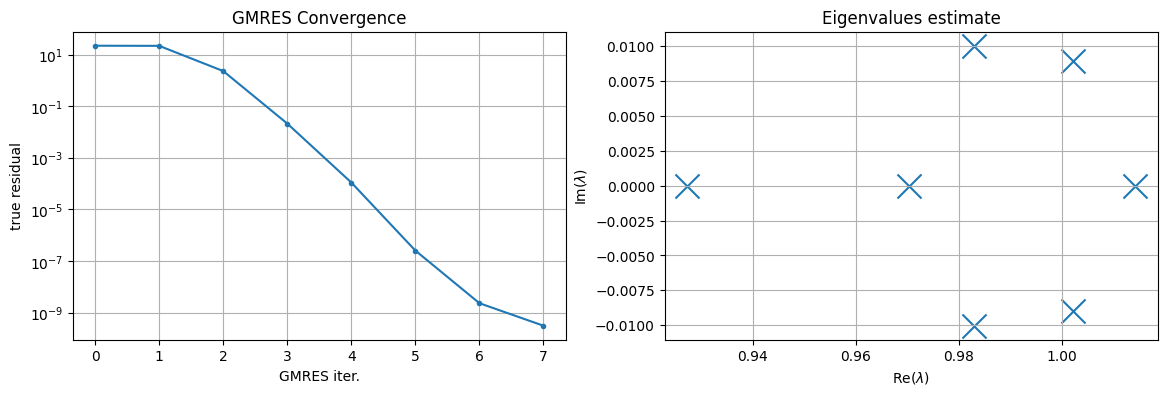

In [87]:
J06 = model.bmat[[0, 6]]
_ = solve_petsc_new(
    J06,
    prec=TwoStagePreconditioner(J06),
)